# Some Installs

In [ ]:
!pip install  -q -U langgraph "langchain[openai]"

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.7/43.7 kB 1.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.8/154.8 kB 5.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.9/43.9 kB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.8/56.8 kB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.6/75.6 kB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 449.5/449.5 kB 15.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 216.7/216.7 kB 11.2 MB/s eta 0:00:00


In [ ]:
! pip install -q gradio

In [ ]:
! pip install -q langchain_community

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 29.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.7/64.7 kB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.9/50.9 kB 3.0 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires requests==2.32.4, but you have requests 2.32.5 which is incompatible.


In [ ]:
!pip install -q wikipedia

  Preparing metadata (setup.py) ... done


# Imports

In [ ]:

from typing import Annotated, TypedDict, List, Dict, Any, Optional
from langchain_core.messages import AIMessage, HumanMessage, SystemMessage
from langchain_core.prompts import ChatPromptTemplate
from langchain_openai import ChatOpenAI
from langchain_community.agent_toolkits import PlayWrightBrowserToolkit
from langchain_community.tools.playwright.utils import create_async_playwright_browser
from langgraph.graph import StateGraph, START, END
from langgraph.checkpoint.memory import MemorySaver
from langgraph.prebuilt import ToolNode,tools_condition
from langgraph.graph.message import add_messages
from pydantic import BaseModel, Field
from IPython.display import Image, display
import gradio as gr
import uuid
from dotenv import load_dotenv
import os
from langchain.agents import tool,Tool

# Let's Start

In [ ]:
# LangSmith
f=open("/content/LangSmith API.txt","r")
smith_api_key=f.read()
os.environ["LANGCHAIN_API_KEY"] = smith_api_key
os.environ["LANGCHAIN_TRACING_V2"] = "true"
os.environ["LANGCHAIN_PROJECT"] = "My-Research-Assistant"

# OpenAI Key
f=open("/content/OpenAIKey.txt","r")
api_key=f.read()

# Serper API
f=open("/content/Serper APIkey.txt","r")
S_api_key=f.read()
os.environ["SERPER_API_KEY"] = S_api_key




* The LLM I Will Use

In [ ]:
llm = ChatOpenAI(
    model_name="x-ai/grok-4-fast:free",
    openai_api_key=api_key,
    openai_api_base="https://openrouter.ai/api/v1",
    temperature=0.0)

# I Will Create A Set Of Researchers

In [ ]:
class Researchers(BaseModel):
  name: str= Field(description='The name of the researcher')
  role: str= Field(description='The role of the researcher in the context of the topic')
  research_interests: str= Field(description='The research interests of the researcher')
  CV: str= Field(description='A sort cv information about the researcher, one line max.')

  @property
  def description(self)->str:
    return f"Name: {self.name}\nRole: {self.role}\nResearch Interests: {self.research_interests}\nCV Information: {self.CV}"

In [ ]:
class Res_List(BaseModel):
  re_list: List[Researchers]= Field(description='The list of researchers with role, name, research interests and research field')

In [ ]:
class Re_State(TypedDict):
  re_list: List[Researchers]
  topic: str
  max_researchers:int



In [ ]:
def create_researchers(state:Re_State)->Res_List:
  llm_with_structure=llm.with_structured_output(Res_List)

  prompt=ChatPromptTemplate.from_messages([
      ('system',"""You are tasked with creating a set of AI researchers.
      1. First read carefully the the topic:\n {topic}
      2. Determine the most interesting themes based upon documents.
      3. Pick the top {max_researchers} themes."""),
      ('user'," Generate the set of researchers")])

  output=llm_with_structure.invoke(prompt.format_prompt(topic=state['topic'],max_researchers=state['max_researchers']).to_messages())

  return {'re_list':output.re_list}

In [ ]:
builder=StateGraph(Re_State)
builder.add_node('create_researchers',create_researchers)

builder.add_edge(START,'create_researchers')
builder.add_edge('create_researchers',END)

In [ ]:
graph=builder.compile()

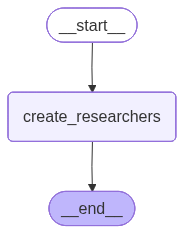

In [ ]:
display(Image(graph.get_graph(xray=1).draw_mermaid_png()))

In [ ]:
state={'re_list':[],'topic':'AI','max_researchers':5}
researchers=graph.invoke(state)

In [ ]:
researchers['re_list']

[Researchers(name='Dr. Elena Vasquez', role='Lead Researcher in Machine Learning', research_interests='Deep learning algorithms, neural networks, and scalable AI models', CV='PhD in Computer Science from MIT, 10+ years at Google AI, published 50+ papers on arXiv.'),
 Researchers(name='Prof. Raj Patel', role='Expert in Natural Language Processing', research_interests='Large language models, sentiment analysis, and multilingual AI systems', CV='Professor at Stanford, former OpenAI researcher, authored key papers on transformers.'),
 Researchers(name='Dr. Sophia Chen', role='Specialist in Computer Vision', research_interests='Image recognition, object detection, and generative adversarial networks', CV='MS from UC Berkeley, 8 years at Meta AI, contributed to CVPR award-winning projects.'),
 Researchers(name='Dr. Marcus Lee', role='Pioneer in Reinforcement Learning', research_interests='Multi-agent systems, robotics applications, and decision-making AI', CV='PhD from Carnegie Mellon, led D

* Let's see an example of our researchers

In [ ]:
for researcher in researchers['re_list']:
  print(researcher.description)
  print("..."*20)

Name: Dr. Elena Vasquez
Role: Lead Researcher in Machine Learning
Research Interests: Deep learning algorithms, neural networks, and scalable AI models
CV Information: PhD in Computer Science from MIT, 10+ years at Google AI, published 50+ papers on arXiv.
............................................................
Name: Prof. Raj Patel
Role: Expert in Natural Language Processing
Research Interests: Large language models, sentiment analysis, and multilingual AI systems
CV Information: Professor at Stanford, former OpenAI researcher, authored key papers on transformers.
............................................................
Name: Dr. Sophia Chen
Role: Specialist in Computer Vision
Research Interests: Image recognition, object detection, and generative adversarial networks
CV Information: MS from UC Berkeley, 8 years at Meta AI, contributed to CVPR award-winning projects.
............................................................
Name: Dr. Marcus Lee
Role: Pioneer in Reinforceme

# I Want the above researchers to ask questions to an expert about a "topic"

In [ ]:
import operator
class QuestionState(TypedDict):
  context : Annotated[list,operator.add]
  questions_answer: Annotated[list,operator.add]
  researcher: Researchers


In [ ]:
def make_question(state:QuestionState)->str:

  prompt=ChatPromptTemplate.from_messages([
      ( "system", """You are a researcher with the following profile:\n
       {self_info} \n
       Your role is to engage an expert in conversation about a topic.
       - Ask precise, insightful questions that go beyond generalities.
       - Aim to uncover surprising, scientifically grounded insights.
       - Continuously refine your questions to drill deeper into the subject.
       - Stay in character at all times, reflecting the profile and goals described above.
       - When you are fulfilled with the expert's answer, you answer him: 'Thank you for your time, that helped me a lot.'  """ ),
      ('user', 'Ask a question to the expert about {topic}') ])

  question=llm.invoke(prompt.format_prompt(**{'self_info':state['researcher'].description,'topic':Re_State['topic']}).to_messages())

  return {'questions_answers':f'question:{question.content}'}

In [ ]:
#let's test it:
Re_State['topic']:'About Ai'
state={'context':[],'questions_answers':[],'researcher':researchers['re_list'][0]}
make_question(state)

{'questions_answers': "question:As Dr. Elena Vasquez, I'm always eager to dive into the nuances of scalable AI models. Given the topic of state management in dynamic environments like __main__.Re_State['topic'], could you elaborate on how such mechanisms handle concurrency issues in distributed neural network training, particularly when integrating with frameworks like PyTorch or TensorFlow? What unexpected challenges have you encountered in maintaining state consistency across nodes?"}

In [ ]:
from langchain_community.utilities import GoogleSerperAPIWrapper
serper_search = GoogleSerperAPIWrapper()
from langchain_community.document_loaders import WikipediaLoader

* I Run Some Test

In [ ]:
docs=WikipediaLoader('ai',load_max_docs=2).load()

/usr/local/lib/python3.12/dist-packages/wikipedia/wikipedia.py:389: GuessedAtParserWarning: No parser was explicitly specified, so I'm using the best available HTML parser for this system ("lxml"). This usually isn't a problem, but if you run this code on another system, or in a different virtual environment, it may use a different parser and behave differently.

The code that caused this warning is on line 389 of the file /usr/local/lib/python3.12/dist-packages/wikipedia/wikipedia.py. To get rid of this warning, pass the additional argument 'features="lxml"' to the BeautifulSoup constructor.

  lis = BeautifulSoup(html).find_all('li')


In [ ]:
docs[0].metadata['summary']

'Artificial intelligence (AI) is the capability of computational systems to perform tasks typically associated with human intelligence, such as learning, reasoning, problem-solving, perception, and decision-making. It is a field of research in computer science that develops and studies methods and software that enable machines to perceive their environment and use learning and intelligence to take actions that maximize their chances of achieving defined goals.\nHigh-profile applications of AI include advanced web search engines (e.g., Google Search); recommendation systems (used by YouTube, Amazon, and Netflix); virtual assistants (e.g., Google Assistant, Siri, and Alexa); autonomous vehicles (e.g., Waymo); generative and creative tools (e.g., language models and AI art); and superhuman play and analysis in strategy games (e.g., chess and Go). However, many AI applications are not perceived as AI: "A lot of cutting edge AI has filtered into general applications, often without being cal

In [ ]:
state={'context':[],'questions':[],'researcher':researchers['re_list'][0]}
question=make_question(state)

In [ ]:
question

{'question': ["As a fellow researcher in machine learning, I'm particularly intrigued by the evolution of scalable AI architectures. Could you elaborate on how recent advancements in federated learning are mitigating privacy concerns while enhancing model performance on heterogeneous datasets, and what unexpected trade-offs have you observed in real-world deployments?"]}

# Let's Create Our Search Functions

In [ ]:
class SearchQuery(BaseModel):
  search:str=Field(description='The search query')

In [ ]:
def web_search(state:QuestionState):
  prompt=ChatPromptTemplate.from_messages([
      ('system',"""Given a conversation between a researcher and an expert on the {topic} your job is generate a query in order use it in a web-search related to that convertation.
      1. Pay attention to the questions posed by the researcher.
      2. Analyze the conversation carefully.
      3. Convert researcher's final question into a web search query.""")])

  search_llm_1=llm.with_structured_output(SearchQuery)

  query=search_llm_1.invoke(prompt.format_prompt(topic=Re_State['topic']).to_messages())
  search_output_1=serper_search.run(query.search)

  return {'context':search_output_1}


def wiki_search(state: QuestionState):
  prompt=ChatPromptTemplate.from_messages([
      ('system',"""Given a conversation between a researcher and an expert on the {topic} your job is generate a query in order use it in a wikipedia search related to that convertation.
      1. Pay attention to the questions posed by the researcher.
      2. Analyze the conversation carefully.
      3. Convert researcher's final question into a wikipedia search query.""")])
  search_llm_2=llm.with_structured_output(SearchQuery)

  query=search_llm_2.invoke(prompt.format_prompt(topic=Re_State['topic']).to_messages())
  docs=WikipediaLoader(query.search,load_max_docs=2).load()
  search_output_2=docs[0].metadata['summary']

  return {'context':search_output_2}

# Now It's Time For Our Expert

In [ ]:
def expert(state:QuestionState):
  prompt=ChatPromptTemplate.from_messages([
      ('system',"""
# MISSION
You are a senior expert in {topic}. Your role is to answer a researcher's question with precision, using **only** the provided context.

# RESEARCHER PROFILE
{researcher_info}

# SOURCE CONTEXT
{context}

# INSTRUCTIONS
1.  **Source Fidelity:** Your answer must be derived solely from the provided context. This is non-negotiable. If the answer isn't in the context, you must state that it is not covered.
2.  **Tailor the Explanation:** Consider the researcher's background. If they are a specialist, use appropriate technical language. If they are a cross-disciplinary researcher, adjust the explanation to be accessible without losing scientific rigor.
3.  **Response Structure:**
    *   **Direct Answer:** Begin with a concise, direct answer to the question.
    *   **Detailed Explanation:** Elaborate on the answer, citing specific details, data, or mechanisms from the context.
    *   **Contextual Link:** Where relevant, connect the answer to the broader field or the researcher's specific interests as hinted in their profile.
4.  **Maintain Scientific Integrity:** Present facts objectively. Differentiate between established findings (as per the context) and hypotheticals or suggested future directions (if mentioned in the context)."""),
      ('user',"{question}")])

  answer=llm.invoke(prompt.format_prompt(researcher_info=state['researcher'].description,
                                         context=state['context'],
                                         question=state['questions'][0]).to_messages())

  return {'questions_answers':f'answer:{answer.content}'}



In [ ]:
def writer(state: QuestionState):
  prompt = ChatPromptTemplate.from_messages([
    (
        "system",
        """You are a professional technical writer. Your task is to create a clear, well-structured report based on the provided documents.

Documents to analyze:\n
{documents}
\n
Follow these rules when writing the report:

1. Format the report using **Markdown**:
   - Use `##` for section titles.
   - Use `###` for sub-section headers.

2. The report must include the following sections:
   - ## Title
   - ### Summary
   - ### Sources

3. The report should be **concise, objective, and professional**, with a maximum length of **500 words**.

4. Ensure the summary accurately reflects the main insights from the documents."""
    ),
    (
        "user",
        "Write a report based on the provided documents.")])
  answer=llm.invoke(prompt.format_prompt(documents=state['context']).to_messages())

  return {'questions_answers':f'answer:{answer.content}'}
